In [1]:
import numpy as np
import pandas as pd
import os
import re
import ast
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [2]:
pd.set_option('future.no_silent_downcasting', True)

def split_data_by_null(df):
   """
   Split a given DataFrame into two DataFrames based on whether the rows contain missing values or not.

   Parameters
   ----------
   df : DataFrame
      The DataFrame to be split.

   Returns
   -------
   non_null_df : DataFrame
      The DataFrame containing all the rows without missing values.
   null_df : DataFrame
      The DataFrame containing all the rows with missing values.
   """
   non_null_df = df.dropna()
   null_df = df[df.isnull().any(axis=1)]
   return non_null_df, null_df

def replace_flags_with_nan(df, flags=['N/A', '']):
   """
   Replace specified flags (e.g., 'N/A', '') in the DataFrame with np.nan.

   Parameters
   ----------
   df : pd.DataFrame
      The DataFrame containing the data to be processed.
   flags : list of str
      List of flag values to replace with np.nan (default: ['N/A', '']).

   Returns
   -------
   pd.DataFrame
      The DataFrame with flags replaced by np.nan.
   """
   # Replace flags with np.nan
   for flag in flags:
      df.replace(flag, None, inplace=True)
        
   return df

def clean_numeric_columns(df, numeric_columns=None):
   """
   Clean and convert columns to numeric, handling various data inconsistencies.
    
   Parameters:
   -----------
   df : pd.DataFrame
      Input DataFrame to clean
   numeric_columns : list, optional
      List of columns to clean. If None, attempts to clean all numeric-like columns.
    
   Returns:
   --------
   pd.DataFrame: Cleaned DataFrame with numeric columns
   """
   # If no columns specified, identify potential numeric columns
   if numeric_columns is None:
      numeric_columns = df.select_dtypes(include=['object']).columns

   for col in numeric_columns:
      try:
         # Remove non-numeric characters, keeping decimals
         df[col] = df[col].astype(str).apply(lambda x: re.sub(r'[^\d.]', '', x))
            
         # Convert to numeric, coercing errors to NaN
         df[col] = pd.to_numeric(df[col], errors='coerce')
        
      except Exception as e:
         print(f"Error cleaning column {col}: {e}")
    
   return df

def split_date_and_place(date_str):
   """
   Split a string in the format 'Date (Place)' into a tuple of (Date, Place)

   Parameters
   ----------
   date_str : str
       The string to be split.

   Returns
   -------
   tuple
      A tuple of (Date, Place). If the string does not match the format, returns (None, None).
   """
   if not isinstance(date_str, str) or date_str.strip().lower() == "n/a":
      return None, None
   
   match = re.match(r'^(.*\d{4}) \((.*)\)$', date_str)

   if match:
      if match.group(1) and match.group(2):
         date = match.group(1) 
         place = match.group(2)
      elif match.group(1):
         date = match.group(1)
         place = None
      elif match.group(2):
         date = None
         place = match.group(2)
      else:
         date = None
         place = None

   return date, place


def parse_duration(duration):
   """
   Parse a duration string in the format 'Xh Ym' to minutes.

   Parameters
   ----------
   duration : str
      The duration string to be parsed.

   Returns
   -------
   int
      The duration in minutes or None if the format is invalid.
   """
   if duration is not str:
      duration = str(duration)

   match = re.match(r'(?:(\d+)h)? ?(?:(\d+)m)?', duration)
    
   if match:
      hours = int(match.group(1)) if match.group(1) else 0
      minutes = int(match.group(2)) if match.group(2) else 0
      return hours * 60 + minutes
   return None

def parse_money(value):
   """
   Parse a string representing money to an integer in cents.

   Parameters
   ----------
   value : str or int
      The string to be parsed.

   Returns
   -------
   int
      The parsed value in cents or numpy.nan if the format is invalid.
   """
   if isinstance(value, str) and value.startswith('$'):
      return int(value.replace('$', '').replace(',', '').split()[0])
   return np.nan

def process_parent_guide(parent_guide):
   # Safely evaluate string to dictionary
   """
   Process a string representing a parent guide to a dictionary of features.

   Parameters
   ----------
   parent_guide : str
      The string to be processed.

   Returns
   -------
   pd.Series
      A pandas Series containing the extracted features.
   """
   guide_dict = ast.literal_eval(parent_guide)
        
   # Prepare a dictionary to hold the extracted features
   features = {}
        
   for category, details in guide_dict.items():
      # Extract features for each category
      features[f"{category}_Severity"] = details.get('Severity', None)
      features[f"{category}_Number_of_votes"] = details.get('Number of vote:', None)
            
      # Handle 'Total votes' (key mismatch handling)
      features[f"{category}_Total_votes"] = details.get('Total votes:', details.get('Total votes', None))
        
   return pd.Series(features)

def encoding(df, top_threshold):
   """
   Encode all categorical columns in a DataFrame using one-hot encoding, with multi-value columns handled
   by splitting and exploding the values.

   Parameters
   ----------
   df : pd.DataFrame
      The DataFrame to be encoded.
   top_threshold : int
      The number of top values to consider for encoding.

   Returns
   -------
   pd.DataFrame, dict
      A tuple containing the encoded DataFrame and a dictionary of encoding information.
   """
   # Define columns to exclude from encoding
   exclude_columns = ['Year', 'Duration', 'Rating', 'Number of votes', 'Critic Reviews', 
                       'Metascore', 'Budget', 'Gross Worldwide', 'Profit Margin', 'Release Date', 
                       'Popularity', 'Popularity Delta']

   data = df.copy()
   
   exclude_columns_df = data[exclude_columns].copy()
   choosed_columns = [col for col in data.columns if col not in exclude_columns]
   encoded_columns_info = {
      'top_values': {},
      'multi_value_columns': []
   }
   one_hot_columns_list = []

   for col in choosed_columns:
      column_data = data[col].astype(str)
      is_multi_value = column_data.str.contains('|').any()
        
      if is_multi_value:
         unique_values = column_data.str.split('|').explode().value_counts().head(top_threshold).index.tolist()
         encoded_columns_info['multi_value_columns'].append(col)
      else:
         unique_values = column_data.value_counts().head(top_threshold).index.tolist()
        
      encoded_columns_info['top_values'][col] = unique_values

      one_hot_cols = {}
      for val in unique_values:
         if is_multi_value:
            one_hot_cols[f"{col}_{val}"] = column_data.apply(lambda x: 1 if val in str(x).split('|') else 0)
         else:
            one_hot_cols[f"{col}_{val}"] = (column_data == val).astype(int)
        
      one_hot_df = pd.DataFrame(one_hot_cols)
      one_hot_columns_list.append(one_hot_df)

   data.drop(columns=choosed_columns, inplace=True)
   one_hot_encoded = pd.concat(one_hot_columns_list, axis=1)
   result_data = pd.concat([exclude_columns_df, data, one_hot_encoded], axis=1)

   print("Total columns after encoding:", result_data.columns)
   print("Number of encoded columns:", len(result_data.columns))

   return result_data, encoded_columns_info

def decoding(data, encoded_columns_info):
   """
   Decodes a DataFrame from one-hot encoded categorical columns into a single column with original categorical values.

   Parameters
   ----------
   data : pd.DataFrame
      Input DataFrame to decode
   encoded_columns_info : dict
      Dictionary containing information about which columns were one-hot encoded and their top values

   Returns
   -------
   pd.DataFrame: Decoded DataFrame with original categorical columns
   """
   
   decoded_data = data.copy()

   # Get top values and multi-value columns from the info dictionary
   top_values = encoded_columns_info['top_values']
   multi_value_columns = encoded_columns_info['multi_value_columns']

   for original_col, values in top_values.items():
      relevant_columns = [col for col in data.columns if col.startswith(f"{original_col}_")]
        
      print(f"Decoding {original_col}")
      print(f"Relevant columns: {relevant_columns}")
      print(f"Top values: {values}")

      if relevant_columns:
         # Determine decoding method based on column type
         if original_col in multi_value_columns:
            # Multi-value column decoding
            def decode_multi_row(row):
               """
               Decode a row of one-hot encoded columns into a single multi-value string.

               Parameters
               ----------
               row : pd.Series or list
                  The row containing one-hot encoded values for a particular column.

               Returns
               -------
               str
                  A string of top values joined by '|' if any are present, otherwise an empty string.
               """
               present_values = [val for val, is_present in zip(values, row) if is_present]
               return '|'.join(present_values) if present_values else ''

            decoded_column = decoded_data[relevant_columns].apply(decode_multi_row, axis=1)

         else:
            # Single-value column decoding
            def decode_single_row(row):
               """
               Decode a row of one-hot encoded columns into a single categorical string.

               Parameters
               ----------
               row : pd.Series or list
                  The row containing one-hot encoded values for a particular column.

               Returns
               -------
               str
                  A string of the single present value if any are present, otherwise an empty string.
               """
               present_values = [val for val, is_present in zip(values, row) if is_present]
               return present_values[0] if present_values else ''

            decoded_column = decoded_data[relevant_columns].apply(decode_single_row, axis=1)

         decoded_column.name = original_col

         # Replace the encoded columns with the decoded column
         decoded_data[original_col] = decoded_column
         decoded_data.drop(columns=relevant_columns, inplace=True)

   return decoded_data

def encode_and_impute(data, columns_to_encode, top_threshold=200):
   """
   Safely encode categorical columns and handle missing values.
    
   Parameters:
   -----------
   data : pd.DataFrame
      Input DataFrame to be processed
   columns_to_encode : list
      List of columns to be one-hot encoded
   top_threshold : int, optional
      Number of top values to consider for encoding
    
   Returns:
    --------
   pd.DataFrame: Processed DataFrame with encoded columns
   dict: Encoding information for potential decoding
   """
   processed_data = data.copy()
    
   # Encoding information to store
   encoding_info = {
      'top_values': {},
      'multi_value_columns': []
   }
    
   # List to store one-hot encoded columns
   one_hot_columns = []
    
   # Process each column for encoding
   for col in columns_to_encode:
      # Convert to string and handle potential multi-value columns
      column_data = processed_data[col].astype(str)
        
      # Check if it's a multi-value column
      is_multi_value = column_data.str.contains('|').any()
        
      # Get unique values
      if is_multi_value:
         unique_values = column_data.str.split('|').explode().value_counts().head(top_threshold).index.tolist()
         encoding_info['multi_value_columns'].append(col)
      else:
         unique_values = column_data.value_counts().head(top_threshold).index.tolist()
        
      # Store top values
      encoding_info['top_values'][col] = unique_values
        
      # Create one-hot encoded columns
      for val in unique_values:
         if is_multi_value:
            one_hot_cols = column_data.apply(lambda x: 1 if val in str(x).split('|') else 0)
         else:
            one_hot_cols = (column_data == val).astype(int)
            
         one_hot_cols.name = f"{col}_{val}"
         one_hot_columns.append(one_hot_cols)
    
   # Remove original categorical columns and add one-hot encoded columns
   processed_data = processed_data.drop(columns=columns_to_encode)
   processed_data = pd.concat([processed_data] + one_hot_columns, axis=1)
    
   return processed_data, encoding_info

def safe_impute_missing_values(data, good_data, max_iter=5):
   """
   Safely impute missing values using multiple strategies.
    
   Parameters:
   -----------
   data : pd.DataFrame
      DataFrame with missing values to impute
   good_data : pd.DataFrame
      Reference DataFrame with complete data
   max_iter : int, optional
      Maximum number of imputation iterations
    
   Returns:
   --------
   pd.DataFrame: Imputed DataFrame
   """

   # Create a copy of the data
   impute_data = data.copy()
    
   # Identify columns with missing values
   columns_with_missing = impute_data.columns[impute_data.isnull().any()].tolist()
    
   # Separate numeric and categorical columns
   numeric_columns = impute_data.select_dtypes(include=['int64', 'float64']).columns
   categorical_columns = impute_data.select_dtypes(include=['object']).columns
    
   # Iteration to improve imputation
   for iteration in range(max_iter):
      print(f"Imputation Iteration {iteration + 1}")
        
      # Impute numeric columns
      for col in numeric_columns:
         if impute_data[col].isnull().any():
            try:
               # Prepare features and target
               feature_columns = [c for c in impute_data.columns if c != col]
                    
               # Separate complete and missing rows
               complete_mask = impute_data[col].notnull()
               missing_mask = impute_data[col].isnull()
                    
               # Ensure we have complete rows to train on
               if complete_mask.sum() > 0:
                  X_train = impute_data.loc[complete_mask, feature_columns]
                  y_train = impute_data.loc[complete_mask, col]
                  X_predict = impute_data.loc[missing_mask, feature_columns]
                        
                  # Use Random Forest for imputation
                  model = RandomForestRegressor(n_estimators=100, random_state=42)
                  model.fit(X_train, y_train)
                        
                  # Predict and fill missing values
                  predicted_values = model.predict(X_predict)
                  impute_data.loc[missing_mask, col] = predicted_values
                
            except Exception as e:
               print(f"Error imputing numeric column {col}: {e}")
               # Fallback to simple mean imputation
               impute_data[col] = impute_data[col].fillna(impute_data[col].mean())
        
      # Impute categorical columns
      for col in categorical_columns:
         if impute_data[col].isnull().any():
            try:
               # Prepare features and target
               feature_columns = [c for c in impute_data.columns if c != col]
                    
               # Separate complete and missing rows
               complete_mask = impute_data[col].notnull()
               missing_mask = impute_data[col].isnull()
                    
               # Ensure we have complete rows to train on
               if complete_mask.sum() > 0:
               # Label encode the target column
                  le = LabelEncoder()
                  y_train_encoded = le.fit_transform(impute_data.loc[complete_mask, col])
                        
                  X_train = impute_data.loc[complete_mask, feature_columns]
                  X_predict = impute_data.loc[missing_mask, feature_columns]
                        
                  # Use Random Forest for imputation
                  model = RandomForestClassifier(n_estimators=100, random_state=42)
                  model.fit(X_train, y_train_encoded)
                        
                  # Predict and fill missing values
                  predicted_encoded = model.predict(X_predict)
                  predicted_values = le.inverse_transform(predicted_encoded)
               impute_data.loc[missing_mask, col] = predicted_values
                
            except Exception as e:
               print(f"Error imputing categorical column {col}: {e}")
               # Fallback to mode imputation
               impute_data[col] = impute_data[col].fillna(impute_data[col].mode()[0]).astype(impute_data[col].dtype)
    
   return impute_data

def process_large_bad_data(bad_data, good_data, chunk_size=1000):
   """
   Process large bad_data in chunks to avoid memory issues.
    
   Parameters:
   -----------
   bad_data : pd.DataFrame
      Data with missing values to be imputed
   good_data : pd.DataFrame
      Fully preprocessed data without missing values
   chunk_size : int, optional
      Number of rows to process in each chunk (default: 1000)
    
   Returns:
   --------
   pd.DataFrame: Fully imputed data
   """
   # Reset index to avoid duplicate label issues
   bad_data = bad_data.reset_index(drop=True)
    
   # Initialize an empty DataFrame to store imputed results
   fully_imputed_data = pd.DataFrame()
    
   # Process data in chunks
   for start in range(0, len(bad_data), chunk_size):
      end = min(start + chunk_size, len(bad_data))
      print(f"Processing bad_data chunk from row {start} to {end}")
        
      # Select current chunk
      current_chunk = bad_data.iloc[start:end]
        
      # Impute current chunk
      imputed_chunk = safe_impute_missing_values(current_chunk, good_data)
        
      # Append to results
      fully_imputed_data = pd.concat([fully_imputed_data, imputed_chunk], ignore_index=True)
    
   return fully_imputed_data

def preprocessing_chunk(df):
   """
   Preprocess a given Pandas DataFrame.

   Parameters
   ----------
   df : Pandas DataFrame
      The DataFrame to be preprocessed.
   only_first_genre : bool, optional
      Whether to only consider the first genre for each movie or not (default: False).
   top_threshold : int, optional
      The number of top actors and genres to consider for one-hot encoding (default: 200).

   Returns
   -------
   good_data, bad_data : tuple of two Pandas DataFrames
      The preprocessed DataFrame is split into two parts: good_data and bad_data.
      good_data contains the preprocessed data without outliers or null values.
      bad_data contains the outliers and null values that were removed from good_data.
   """
   data = df.copy()
   good_data = pd.DataFrame()
   bad_data = pd.DataFrame()

   # Drop duplicates
   data = data.drop_duplicates()

   # Process Parental Guide
   processed_features = data['Parental Guide'].apply(process_parent_guide)
   data = pd.concat([data, processed_features], axis=1)
   data = data.drop(columns=['Parental Guide'])

   data = replace_flags_with_nan(data)
   # Drop columns with entirely null values
   data = data.drop(columns=['Type', 'Watchlist Count', 'Runtime'])

   # Convert Runtime to minutes
   data['Duration'] = data['Duration'].apply(parse_duration)

   # Split Release Date and Place
   data['Release Date'], data['Place'] = zip(*data['Release Date'].apply(split_date_and_place))

   #data['Release Year'] = pd.to_datetime(data['Release Date'], errors='coerce').dt.year

   data['Sound Mix'] = data['Sound Mix'].apply(lambda x: None if x == 'N|/|A' else x)
   
   # Parse Budget and Gross Worldwide to numeric values
   data['Budget'] = data['Budget'].apply(parse_money)
   data['Gross Worldwide'] = data['Gross Worldwide'].apply(parse_money)

   # Add Profit Margin and (? Profit Margin Ratio)
   if not data['Gross Worldwide'].isna().all() or not data['Budget'].isna().all():
      data['Profit Margin'] = data['Gross Worldwide'] - data['Budget']
      #data['Profit Margin Ratio'] = (data['Gross Worldwide'] - data['Budget']) / data['Budget']
 
   numeric_columns = []
    
   if numeric_columns is None:
      # Automatically detect candidate numeric columns
      numeric_columns = [
         'Year', 'Rating', 'Number of votes', 'Critic Reviews', 
         'Metascore', 'Budget', 'Gross Worldwide'
      ]
    
   # Clean numeric columns
   data = clean_numeric_columns(data, numeric_columns)

   # Encode categorical columns
   good_data,bad_data = split_data_by_null(data)
   imputed_bad_data = process_large_bad_data(bad_data, good_data, 1000)
   
   # Identify numerical columns for outlier detection
   numerical_columns = ['Rating', 'Number of votes', 'Critic Reviews', 'Metascore', 'Budget', 'Gross Worldwide']
   outliers = {col: good_data[col][(good_data[col] - good_data[col].mean()).abs() > 3 * data[col].std()]
               for col in numerical_columns}

   for col, outlier_values in outliers.items():
      bad_data = pd.concat([bad_data, good_data[good_data[col].isin(outlier_values)]])
      good_data = good_data[~good_data[col].isin(outlier_values)]

   return good_data, imputed_bad_data

def preprocessing(df, chunk_size, output_file_good, output_file_bad):
   """
   Process data in chunks and save each chunk incrementally to CSV files.

   Parameters
   ----------
   df : DataFrame or str
      The DataFrame or path to the CSV file containing the data to be processed.
   chunk_size : int
      Number of rows to process in each chunk.
   output_file_good : str
      File path to save the processed "good" data.
   output_file_bad : str
      File path to save the "bad" data.
   

   Notes
   -----
   Appends the results of each chunk to the output files, avoiding memory overload.
   If the output files do not exist, they will be created with headers.
   """
   # Load the data if a file path is provided
   if isinstance(df, str):
      df = pd.read_csv(df)

   total_rows = len(df)
   
   # Check if the output files exist
   good_file_exists = os.path.exists(output_file_good)
   bad_file_exists = os.path.exists(output_file_bad)

   for start in range(0, total_rows, chunk_size):
      end = min(start + chunk_size, total_rows)
      print(f"Processing rows {start} to {end}...")

      # Process the current chunk
      chunk = df.iloc[start:end]
      good_chunk, bad_chunk = preprocessing_chunk(chunk)

      # Append or create files as needed
      # For "good" data
      good_chunk.to_csv(
         output_file_good,
         mode='a',
         header=not good_file_exists,  # Write header only if the file doesn't exist
         index=False,
         encoding='utf-8'
      )
      # Update the existence status
      good_file_exists = True

      # For "bad" data
      bad_chunk.to_csv(
         output_file_bad,
         mode='a',
         header=not bad_file_exists,  # Write header only if the file doesn't exist
         index=False,
         encoding='utf-8'
      )
      
      # Update the existence status
      bad_file_exists = True

      print(f"Saved processed rows {start} to {end}.")



In [3]:
# Filling null
df = 'crawled_web_with_data_request.csv'
output_file_good='good_data.csv'
output_file_bad='null_filled_data.csv'
chunk_size=1000
preprocessing(df, chunk_size, output_file_good, output_file_bad)

data_all = pd.concat((pd.read_csv('good_data.csv', encoding='utf-8'), pd.read_csv('null_filled_data.csv', encoding='utf-8')), axis=0)
data_all.to_csv('all_data.csv', index=False, encoding='utf-8')

Processing rows 0 to 1000...
Processing bad_data chunk from row 0 to 530
Imputation Iteration 1
Error imputing numeric column Metascore: could not convert string to float: 'tt9218128'
Error imputing numeric column Budget: could not convert string to float: 'tt9218128'
Error imputing numeric column Gross Worldwide: could not convert string to float: 'tt9218128'
Error imputing numeric column Profit Margin: could not convert string to float: 'tt9218128'
Error imputing categorical column Writer: could not convert string to float: 'tt9218128'
Error imputing categorical column Sound Mix: could not convert string to float: 'tt9218128'
Error imputing categorical column Color: could not convert string to float: 'tt9218128'
Error imputing categorical column Certificate: could not convert string to float: 'tt28015403'
Error imputing categorical column Languages: could not convert string to float: 'tt9218128'
Error imputing categorical column Production Companies: could not convert string to float

In [4]:
# Read the dataset
data = pd.read_csv('all_data.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126560 entries, 0 to 126559
Data columns (total 40 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   IMDb ID                                       126560 non-null  object 
 1   Director                                      126560 non-null  object 
 2   Writer                                        126560 non-null  object 
 3   Cast                                          126560 non-null  object 
 4   Sound Mix                                     126560 non-null  object 
 5   Color                                         126560 non-null  object 
 6   Year                                          126560 non-null  float64
 7   Certificate                                   126560 non-null  object 
 8   Duration                                      126560 non-null  int64  
 9   Genre                                         12

In [6]:
data.isna().sum()

IMDb ID                                             0
Director                                            0
Writer                                              0
Cast                                                0
Sound Mix                                           0
Color                                               0
Year                                                0
Certificate                                         0
Duration                                            0
Genre                                               0
Release Date                                        0
Country of Origin                                   0
Languages                                           0
Production Companies                                0
Filming Locations                                   0
Critic Reviews                                      0
Metascore                                           0
Budget                                              0
Gross Worldwide             

In [7]:
# These columns may not help the predict so drop first

data_dropped_unwanted_columns = data.drop(columns=['Sex & Nudity_Severity','Sex & Nudity_Number_of_votes','Sex & Nudity_Total_votes','Violence & Gore_Severity','Violence & Gore_Number_of_votes','Violence & Gore_Total_votes','Profanity_Severity','Profanity_Number_of_votes','Profanity_Total_votes','Alcohol, Drugs & Smoking_Severity','Alcohol, Drugs & Smoking_Number_of_votes','Alcohol, Drugs & Smoking_Total_votes','Frightening & Intense Scenes_Severity','Frightening & Intense Scenes_Number_of_votes','Frightening & Intense Scenes_Total_votes'])

In [8]:
data_dropped_unwanted_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126560 entries, 0 to 126559
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   IMDb ID               126560 non-null  object 
 1   Director              126560 non-null  object 
 2   Writer                126560 non-null  object 
 3   Cast                  126560 non-null  object 
 4   Sound Mix             126560 non-null  object 
 5   Color                 126560 non-null  object 
 6   Year                  126560 non-null  float64
 7   Certificate           126560 non-null  object 
 8   Duration              126560 non-null  int64  
 9   Genre                 126560 non-null  object 
 10  Release Date          126560 non-null  object 
 11  Country of Origin     126560 non-null  object 
 12  Languages             126560 non-null  object 
 13  Production Companies  126560 non-null  object 
 14  Filming Locations     126560 non-null  object 
 15  

In [9]:
data_dropped_unwanted_columns.isna().sum()

IMDb ID                 0
Director                0
Writer                  0
Cast                    0
Sound Mix               0
Color                   0
Year                    0
Certificate             0
Duration                0
Genre                   0
Release Date            0
Country of Origin       0
Languages               0
Production Companies    0
Filming Locations       0
Critic Reviews          0
Metascore               0
Budget                  0
Gross Worldwide         0
Rating                  0
Number of votes         0
Popularity              0
Popularity Delta        0
Place                   0
Profit Margin           0
dtype: int64

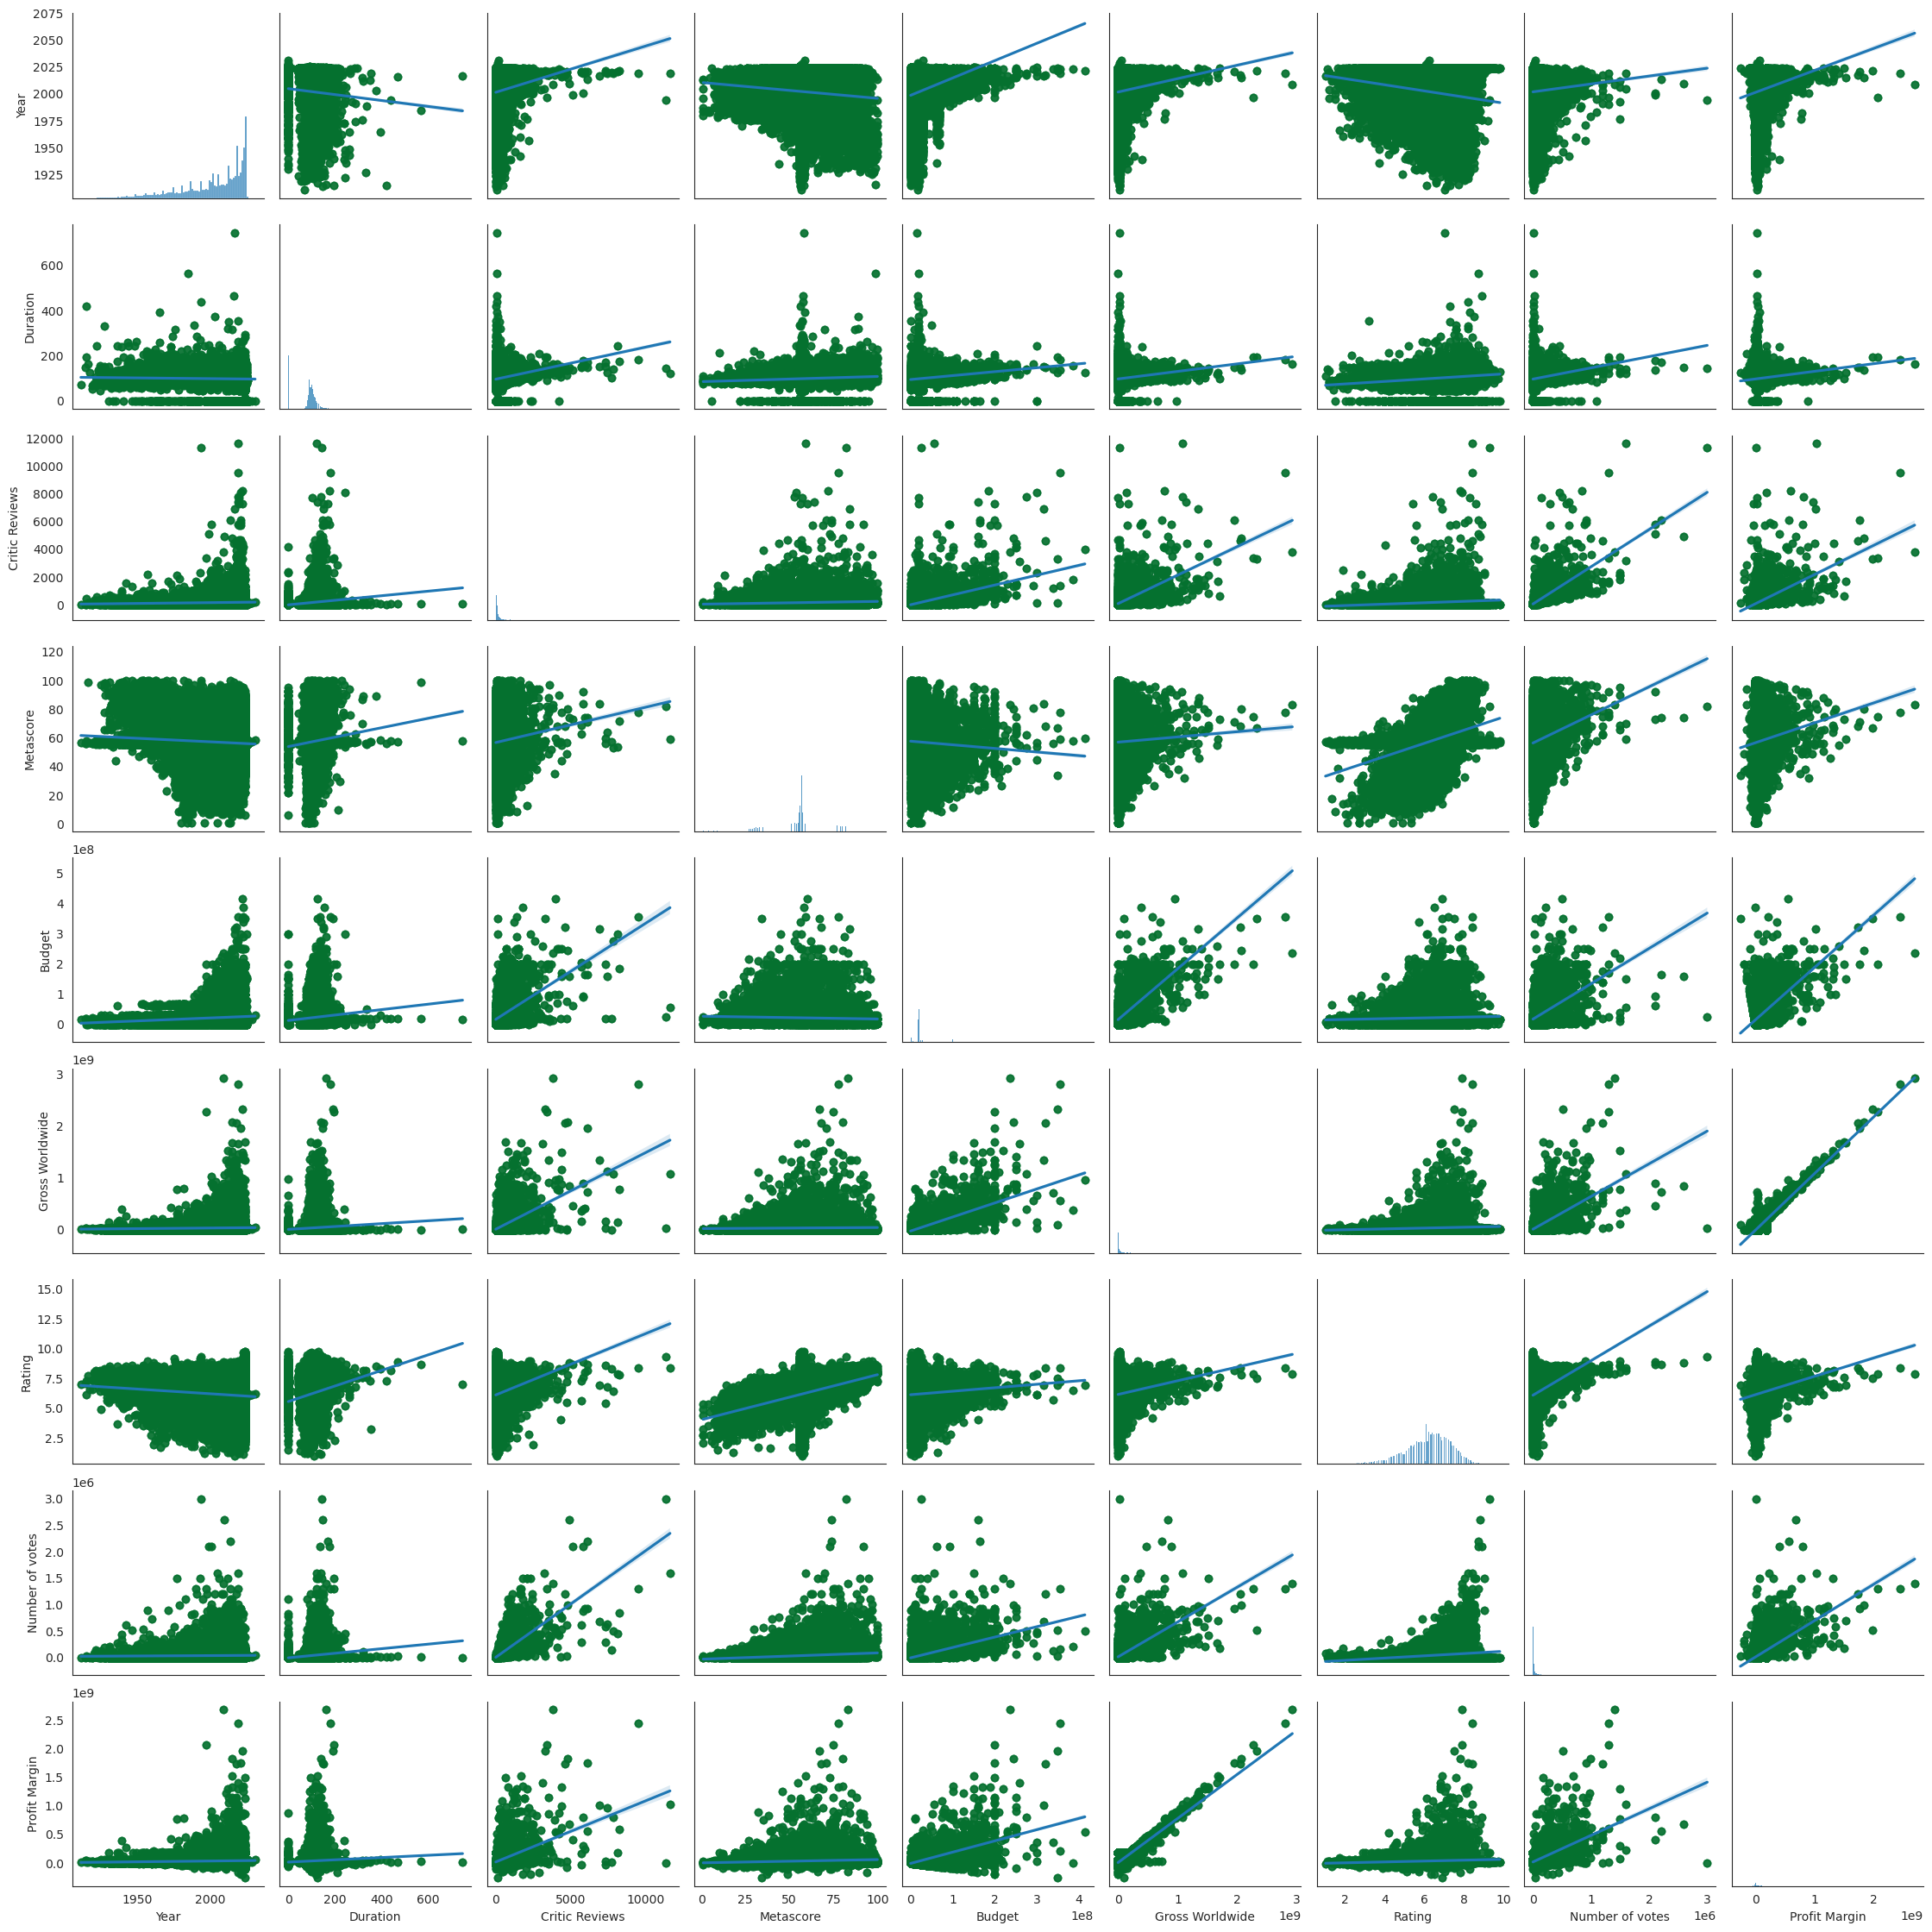

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

features = data_dropped_unwanted_columns.columns
with sns.axes_style('white'):
    g=sns.pairplot(data_dropped_unwanted_columns[features], kind='reg',
                    plot_kws={'scatter_kws' :{'color': sns.color_palette('Greens')[-1], 'alpha': 0.4}})
plt.tight_layout()

In [11]:
# Drop category columns
exclude_columns = ['IMDb ID', 'Cast', 'Production Companies', 'Director', 'Writer']
data_drop_unneeded = data_dropped_unwanted_columns.drop(columns=exclude_columns)

In [12]:
# Get unique data of genre to process
data_drop_unneeded['Genre'].unique().sum()
column_data = data_drop_unneeded['Genre'].astype(str)

value_counts = column_data.str.split('|').explode().value_counts()

for genre, count in value_counts.items():
    print(f"{genre}: {count}")

filtered_genres = value_counts[value_counts >= 1230].index.tolist()

data_filtered = data_drop_unneeded[column_data.str.split('|').apply(lambda x: any(item in filtered_genres for item in x))]

Drama: 69870
Comedy: 39955
Thriller: 37195
Romance: 26040
Action: 24295
Horror: 21570
Crime: 21525
Adventure: 16035
Mystery: 15255
Sci-Fi: 12015
Fantasy: 11645
Family: 8860
Dark Comedy: 7020
Biography: 6670
History: 5325
War: 5165
Animation: 4765
Music: 3750
Documentary: 3490
Musical: 3325
Satire: 3215
Period Drama: 3200
Sport: 3100
Western: 3065
Slasher Horror: 2795
Supernatural Horror: 2710
Slapstick: 2625
Psychological Thriller: 2435
Romantic Comedy: 2145
Tragedy: 2140
Parody: 2130
Psychological Drama: 1820
Superhero: 1720
Coming-of-Age: 1675
True Crime: 1665
Computer Animation: 1600
Docudrama: 1290
Buddy Comedy: 1200
Animal Adventure: 1195
Film Noir: 1175
Anime: 1105
Teen Horror: 1005
Psychological Horror: 980
Martial Arts: 975
Teen Comedy: 960
Space Sci-Fi: 960
Body Horror: 955
One-Person Army Action: 930
Dark Fantasy: 910
Feel-Good Romance: 895
Teen Drama: 885
Supernatural Fantasy: 865
Adult Animation: 855
Farce: 855
Quest: 810
Monster Horror: 795
Dystopian Sci-Fi: 790
Epic: 770


In [13]:
def extract_last_part(value):
    if ',' in value:
        return value.split(',')[-1].strip()
    else:
        return value.strip()

# Process Filming Locations
data_drop_unneeded['Filming Locations'] = data_drop_unneeded['Filming Locations'].astype(str).apply(extract_last_part)

In [14]:
# Encoding some category data column
encode_object = LabelEncoder()
data_drop_unneeded_encoded = data_drop_unneeded.copy()
for col in ['Sound Mix', 'Color', 'Certificate', 'Genre', 'Country of Origin', 'Languages','Release Date','Place', 'Filming Locations']:
    data_drop_unneeded_encoded[col] = encode_object.fit_transform(data_drop_unneeded_encoded[col])

In [15]:
data_drop_unneeded_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126560 entries, 0 to 126559
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Sound Mix          126560 non-null  int64  
 1   Color              126560 non-null  int64  
 2   Year               126560 non-null  float64
 3   Certificate        126560 non-null  int64  
 4   Duration           126560 non-null  int64  
 5   Genre              126560 non-null  int64  
 6   Release Date       126560 non-null  int64  
 7   Country of Origin  126560 non-null  int64  
 8   Languages          126560 non-null  int64  
 9   Filming Locations  126560 non-null  int64  
 10  Critic Reviews     126560 non-null  float64
 11  Metascore          126560 non-null  float64
 12  Budget             126560 non-null  float64
 13  Gross Worldwide    126560 non-null  float64
 14  Rating             126560 non-null  float64
 15  Number of votes    126560 non-null  float64
 16  Po

In [16]:
# Process column
data_drop_unneeded_encoded['Popularity'] = data_drop_unneeded_encoded['Popularity'].str.replace(',', '').astype(int)
data_drop_unneeded_encoded['Popularity Delta'] = data_drop_unneeded_encoded['Popularity Delta'].str.replace(',', '').astype(int)

In [17]:
# Save data milestone
data_drop_unneeded_encoded.to_csv('data_drop_unneeded_encoded.csv')

In [18]:
data_drop_unneeded_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126560 entries, 0 to 126559
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Sound Mix          126560 non-null  int64  
 1   Color              126560 non-null  int64  
 2   Year               126560 non-null  float64
 3   Certificate        126560 non-null  int64  
 4   Duration           126560 non-null  int64  
 5   Genre              126560 non-null  int64  
 6   Release Date       126560 non-null  int64  
 7   Country of Origin  126560 non-null  int64  
 8   Languages          126560 non-null  int64  
 9   Filming Locations  126560 non-null  int64  
 10  Critic Reviews     126560 non-null  float64
 11  Metascore          126560 non-null  float64
 12  Budget             126560 non-null  float64
 13  Gross Worldwide    126560 non-null  float64
 14  Rating             126560 non-null  float64
 15  Number of votes    126560 non-null  float64
 16  Po

In [19]:
data_drop_unneeded_encoded.head()

,Sound Mix,Color,Year,Certificate,Duration,Genre,Release Date,Country of Origin,Languages,Filming Locations,Critic Reviews,Metascore,Budget,Gross Worldwide,Rating,Number of votes,Popularity,Popularity Delta,Place,Profit Margin
0,557,1,2024.0,3,141,1769,7455,1754,187,76,1200.0,78.0,17500000.0,54130377.0,7.5,142000.0,2,1,110,36630377.0
1,1067,1,1982.0,3,124,5034,978,2012,375,225,183.0,75.0,7500000.0,129795890.0,7.1,64000.0,3860,896,107,122295890.0
2,65,1,1984.0,1,124,7662,4446,1984,187,225,209.0,41.0,35000000.0,14296438.0,4.4,25000.0,4937,59,106,-20703562.0
3,1067,1,1978.0,1,114,320,2117,2012,187,225,129.0,41.0,5000000.0,85196485.0,6.3,31000.0,4883,323,107,80196485.0
4,266,1,2005.0,2,124,4204,639,1724,386,141,529.0,41.0,130000000.0,119240351.0,6.1,105000.0,4048,519,110,-10759649.0


In [28]:
categorical_features = ["Sound Mix", "Color", "Year", "Certificate", "Genre", "Release Date", "Country of Origin", "Languages", "Filming Locations", "Place"]

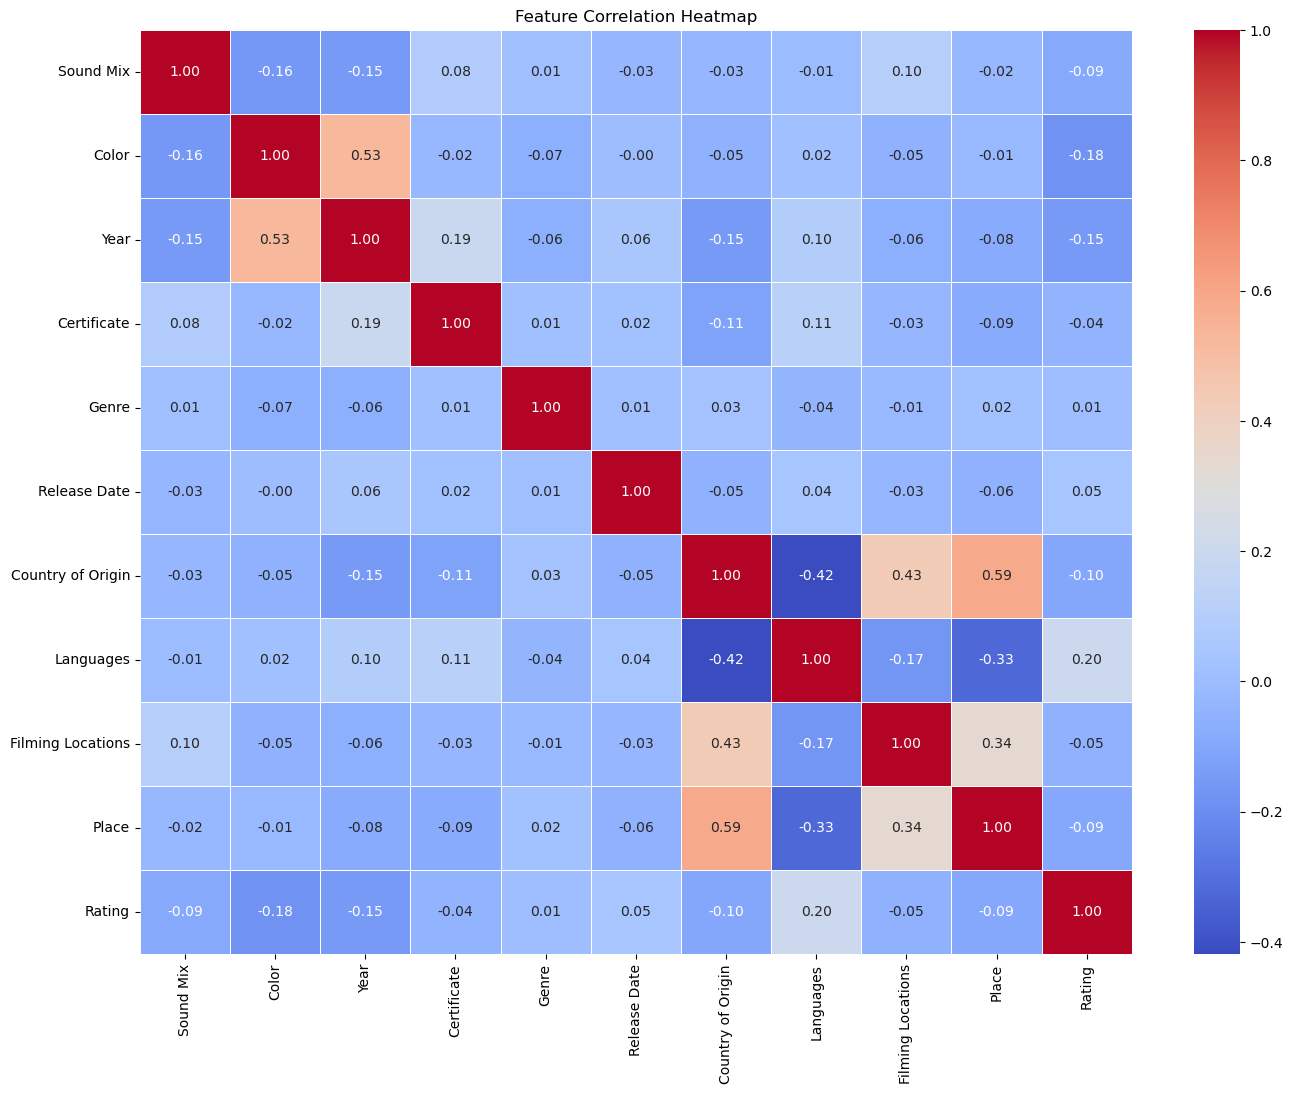

In [41]:
corr_matrix = data_drop_unneeded_encoded[[*categorical_features, "Rating"]].corr()

# Draw heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [42]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif = pd.DataFrame()
    vif['Feature'] = data.columns
    vif['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif

def select_features_based_on_vif(X, categorical_features, threshold=5):
    vif_raw = X.copy()
    for feature in categorical_features:
        vif_raw.drop(feature,axis=1, inplace=True)
    while True:
        vif_df = calculate_vif(vif_raw)
        max_vif = vif_df['VIF'].max()
        if max_vif < threshold:
            break
        drop_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
        print(f"Dropping feature '{drop_feature}' with VIF = {max_vif}")
        X = X.drop(columns=[drop_feature])
        vif_raw = vif_raw.drop(columns=[drop_feature])
    return X, vif_df

In [43]:
# Choosing feature base on vif
data_selected, vif_list = select_features_based_on_vif(data_drop_unneeded_encoded.drop('Rating',axis=1), categorical_features,9)

Dropping feature 'Gross Worldwide' with VIF = 10.240705611557289


In [44]:
vif_list

,Feature,VIF
0,Duration,8.230757
1,Critic Reviews,2.769464
2,Metascore,8.514382
3,Budget,3.024267
4,Number of votes,2.876425
5,Popularity,3.534686
6,Popularity Delta,1.121195
7,Profit Margin,2.199745


In [45]:
data_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126560 entries, 0 to 126559
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Sound Mix          126560 non-null  int64  
 1   Color              126560 non-null  int64  
 2   Year               126560 non-null  float64
 3   Certificate        126560 non-null  int64  
 4   Duration           126560 non-null  int64  
 5   Genre              126560 non-null  int64  
 6   Release Date       126560 non-null  int64  
 7   Country of Origin  126560 non-null  int64  
 8   Languages          126560 non-null  int64  
 9   Filming Locations  126560 non-null  int64  
 10  Critic Reviews     126560 non-null  float64
 11  Metascore          126560 non-null  float64
 12  Budget             126560 non-null  float64
 13  Number of votes    126560 non-null  float64
 14  Popularity         126560 non-null  int64  
 15  Popularity Delta   126560 non-null  int64  
 16  Pl

In [46]:
data_without_drop_pop_delta_place = data_selected.copy()

In [47]:
# Drop Popularity Delta and Place which is not good for predicting
data_selected.drop(columns=['Popularity Delta','Place'], axis=1)

,Sound Mix,Color,Year,Certificate,Duration,Genre,Release Date,Country of Origin,Languages,Filming Locations,Critic Reviews,Metascore,Budget,Number of votes,Popularity,Profit Margin
0,557,1,2024.000,3,141,1769,7455,1754,187,76,1200.000000,78.000000,1.750000e+07,142000.000000,2,3.663038e+07
1,1067,1,1982.000,3,124,5034,978,2012,375,225,183.000000,75.000000,7.500000e+06,64000.000000,3860,1.222959e+08
2,65,1,1984.000,1,124,7662,4446,1984,187,225,209.000000,41.000000,3.500000e+07,25000.000000,4937,-2.070356e+07
3,1067,1,1978.000,1,114,320,2117,2012,187,225,129.000000,41.000000,5.000000e+06,31000.000000,4883,8.019648e+07
4,266,1,2005.000,2,124,4204,639,1724,386,141,529.000000,41.000000,1.300000e+08,105000.000000,4048,-1.075965e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126555,1067,1,1984.000,3,84,6140,5782,2012,187,225,29.000000,57.341346,3.000000e+06,3900.000000,1387,-2.272361e+06
126556,1067,1,2002.366,3,0,527,5975,2012,187,225,100.880412,57.341346,1.718013e+07,20738.449187,1387,2.085858e+07
126557,634,1,2010.000,2,90,4602,7189,2012,187,225,85.000000,57.341346,1.718013e+07,13000.000000,1387,2.085858e+07
126558,1067,1,2025.000,3,0,4464,2790,2012,187,225,100.880412,57.341346,1.718013e+07,20738.449187,1387,2.085858e+07


In [48]:
data_selected['Rating'] = data_drop_unneeded_encoded['Rating']

In [49]:
# Save data milestone
data_selected.to_csv('data_selected_2.csv', index=False)

In [ ]:
# Visualize
for col in data_selected.columns:
    sns.histplot(data_selected[col], kde=False)

    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {col}') 

    plt.show()

In [ ]:
data_normalized = data_selected.copy()

### Normalize:

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler_genre = RobustScaler()
data_normalized['Genre'] = scaler_genre.fit_transform(data_selected[['Genre']])

# Plot the distribution of the scaled data
sns.histplot(data_normalized['Genre'], kde=True)
plt.title('Robust Scaled Genre')
plt.show()


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler_time = MinMaxScaler()
data_normalized['Release Date'] = scaler_time.fit_transform(data_selected[['Release Date']])

# Plot the distribution of the scaled data
sns.histplot(data_normalized['Release Date'], kde=True)
plt.title('Min-Max Release Date')
plt.show()

In [ ]:
from sklearn.preprocessing import QuantileTransformer

trans_languages = QuantileTransformer(output_distribution='normal')
data_normalized['Languages'] = trans_languages.fit_transform(data_normalized[['Languages']])

# Plot the distribution of the scaled data
sns.histplot(data_normalized['Languages'], kde=True)
plt.title('Quantile Transformer Languages')
plt.show()

In [ ]:
trans_critic = QuantileTransformer(output_distribution='normal')
data_normalized['Critic Reviews'] = trans_critic.fit_transform(data_normalized[['Critic Reviews']])

# Plot the distribution of the scaled data
sns.histplot(data_normalized['Critic Reviews'], kde=True)
plt.title('Quantile Transformer Critic Reviews')
plt.show()

In [ ]:
trans_budget = QuantileTransformer(output_distribution='normal')
data_normalized['Budget'] = trans_critic.fit_transform(data_normalized[['Budget']])

# Plot the distribution of the scaled data
sns.histplot(data_normalized['Budget'], kde=True)
plt.title('Quantile Transformer Budget')
plt.show()

In [ ]:
trans_votes = QuantileTransformer(output_distribution='normal')
data_normalized['Number of votes'] = trans_critic.fit_transform(data_normalized[['Number of votes']])

# Plot the distribution of the scaled data
sns.histplot(data_normalized['Number of votes'], kde=True)
plt.title('Quantile Transformer Number of votes')
plt.show()

In [ ]:
trans_popularity = QuantileTransformer(output_distribution='normal')
data_normalized['Popularity'] = trans_popularity.fit_transform(data_normalized[['Popularity']])

# Plot the distribution of the scaled data
sns.histplot(data_normalized['Popularity'], kde=True)
plt.title('Quantile Transformer Popularity')
plt.show()

In [ ]:
trans_profit = QuantileTransformer(output_distribution='normal')
data_normalized['Profit Margin'] = trans_popularity.fit_transform(data_normalized[['Profit Margin']])

# Plot the distribution of the scaled data
sns.histplot(data_normalized['Profit Margin'], kde=True)
plt.title('Quantile Transformer Profit Margin')
plt.show()

In [ ]:
data_normalized['Rating'] = data_drop_unneeded_encoded['Rating']  

In [ ]:
dict_of_data_normalized_scaler = {
    'Genre': scaler_genre,
    'Release Date': scaler_time,
    'Languages': trans_languages,
    'Critic Reviews': trans_critic,
    'Budget': trans_budget,
    'Number of votes': trans_votes,
    'Popularity': trans_popularity,
    'Profit Margin': trans_profit
}

### Split train, val, test and example run test on some model

In [ ]:
from sklearn.model_selection import train_test_split

X = data_normalized.drop('Rating', axis=1)
Y = data_normalized['Rating']

X_temp, X_test, y_temp, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

print("Training shape (X, Y):", X_train.shape, y_train.shape)
print("Validation shape (X, Y):", X_val.shape, y_val.shape)
print("Test shape (X, Y):", X_test.shape, y_test.shape)

In [ ]:
def get_accuracy_details(model, X,y):
    """
    Calculates and prints accuracy details for a given model using provided features and target data.

    Args:
        model: A trained machine learning model with `predict` and `score` methods.
        X: Features data used for making predictions.
        y: True target values corresponding to the features.

    Prints:
        Validation R² score: Coefficient of determination of the prediction.
        Validation Mean Squared Error: Mean of the squared differences between predicted and true values.
        Validation Mean Absolute Error: Mean of the absolute differences between predicted and true values.
    """

    y_pred = model.predict(X)

    # Calculate R² score
    r2_score = model.score(X, y)

    from sklearn.metrics import mean_squared_error, mean_absolute_error
    val_mse = mean_squared_error(y, y_pred)
    val_mae = mean_absolute_error(y, y_pred)

    print(f"Validation R² score: {r2_score}")
    print(f"Validation Mean Squared Error: {val_mse}")
    print(f"Validation Mean Absolute Error: {val_mae}")

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

def train_random_forest(X_train, y_train):
    param_grid = {
        'n_estimators': [50, 200],
        'max_features': [None, 'log2'],
        'bootstrap': [True]
    }
    rf_classifier = RandomForestRegressor(random_state=29)
    grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='r2')
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    best_rf_model = grid_search.best_estimator_
    
    return best_rf_model, best_params

best_rf_model, best_params_rf = train_random_forest(X_train, y_train)
print(f"Random Forest - Best Parameters: {best_params_rf}")

In [ ]:
get_accuracy_details(best_rf_model, X_val, y_val)

In [ ]:
from catboost import CatBoostRegressor

def train_catboost(X_train, y_train):
    param_grid = {
        'iterations': [100, 500],
        'learning_rate': [0.01, 0.1],
        'depth': [6, 10]
    }
    cb_regressor = CatBoostRegressor(random_seed=29, verbose=0)
    grid_search = GridSearchCV(cb_regressor, param_grid, cv=5, scoring='r2')
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    best_cb_model = grid_search.best_estimator_
    
    return best_cb_model, best_params

best_cb_model, best_params_cb = train_catboost(X_train, y_train)
print(f"CatBoost - Best Parameters: {best_params_cb}")


In [ ]:
get_accuracy_details(best_cb_model, X_val, y_val)

In [ ]:
from sklearn.linear_model import Ridge

def train_ridge(X_train, y_train):
    param_grid = {
        'alpha': [0.1, 1.0, 10.0],  
        'solver': ['auto', 'svd', 'cholesky', 'lsqr'] 
    }
    ridge_regressor = Ridge(random_state=29)
    grid_search = GridSearchCV(ridge_regressor, param_grid, cv=5, scoring='r2')
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    best_ridge_model = grid_search.best_estimator_
    
    return best_ridge_model, best_params

best_ridge_model, best_params_ridge = train_ridge(X_train, y_train)
print(f"Ridge Regression - Best Parameters: {best_params_ridge}")

In [ ]:
get_accuracy_details(best_ridge_model, X_val, y_val)